In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam


In [2]:
train = pd.read_csv(r'written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

In [3]:
train_img_dir = 'train_v2/train/'

In [4]:
val_img_dir = 'validation_v2/validation/'

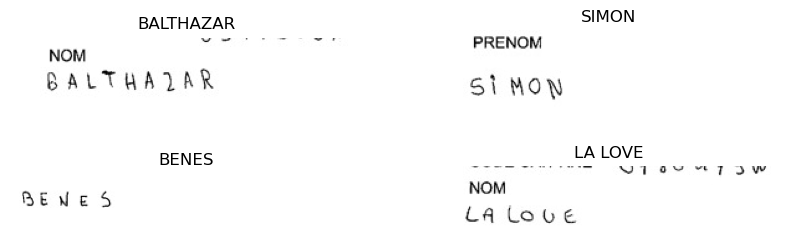

In [5]:
plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    img_dir = train_img_dir+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [6]:
# NaN in the labels
print("Number of NaNs in train set      : ", train['IDENTITY'].isna().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isna().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [7]:
# Dropping the NaNs
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

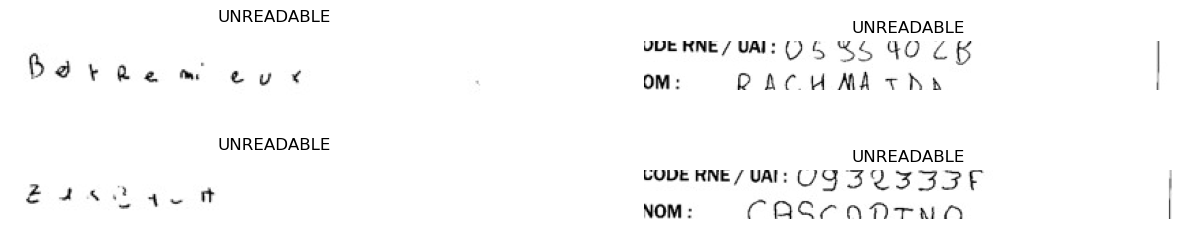

In [8]:
# Some of the images have label 'UNREADABLE'
unread = train[train['IDENTITY'] == 'UNREADABLE']
unread.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    img_dir = train_img_dir+unread.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unread.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
# Removing the Unreadable
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [10]:
# Coverting lowercase to uppercase
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [11]:
# Resetting the index
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [12]:
# Fuction to preprocess the img
def preprocess(img):
    (h, w) = img.shape                                    # Getting the height & width of the image
    
    final_img = np.ones([64, 256])*255                    # Blank white image
    
    # crop    
    if h > 64:
        img = img[:64, :]                                 # If the h>64 then it is cropped to 64
        
    if w > 256:
        img = img[:, :256]                                # If the w>256 then it is cropped to 256
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # Rotate 90° Clockwise & return

In [13]:
train_size = 20000
valid_size = 2000

In [14]:
train_x = []                                                # Initialize a list to store preprocessed images

for i in range(train_size):                                 # Loop through the training dataset
    img_dir = train_img_dir + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)       # Read the image in grayscale
    image = preprocess(image)                               # Apply image preprocessing
    image = image / 255.0                                   # Normalize pixel values to [0, 1]
    train_x.append(image)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} images")

print("Processing complete.")


Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processing complete.


In [15]:
valid_x = []

for i in range(valid_size):                                  # Loop through the validation dataset
    img_dir = val_img_dir  + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)        # Read the image in grayscale
    image = preprocess(image)                                # Apply image preprocessing
    image = image / 255.0                                    # Normalize pixel values to [0, 1]
    valid_x.append(image)

    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} validation images")

print("Validation processing complete.")

Processed 1000 validation images
Processed 2000 validation images
Validation processing complete.


In [16]:
# Convert 'train_x' to a NumPy array and reshape it
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

# Convert 'valid_x' to a NumPy array and reshape it
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [17]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "  # The set of valid characters
max_str_len = 24                             # Maximum length of input labels
num_of_characters = len(alphabets) + 1       # Number of unique characters, plus 1 for CTC pseudo-blank
num_of_timestamps = 64                       # Maximum length of predicted labels

In [18]:
def label_to_num(label):
    label_num = []                            # Initialize an empty list to store character indices
    for ch in label:                          # Iterate over each character in the input label
        label_num.append(alphabets.find(ch))  # Find the index of the character in the 'alphabets' string
        
    return np.array(label_num)                # Convert the list to a NumPy array and return it

In [19]:
def num_to_label(num):
    ret = ""  # Initialize an empty string to store the label
    for ch in num:  # Iterate over each character index in the input list
        if ch == -1:  # Check for the CTC Blank (a special case)
            break
        else:
            ret += alphabets[ch]  # Append the character from 'alphabets' based on the index
    return ret


In [20]:
name = 'UMANG'
print(name, '\n',label_to_num(name))

UMANG 
 [20 12  0 13  6]


In [21]:
blank_label = -1

In [22]:
# Initialize arrays
train_y = np.ones([train_size, max_str_len]) * blank_label
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)
train_output = np.zeros([train_size])

# Loop through the training data
for i in range(train_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = train.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in train_y
    train_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    train_y[i, 0:len(identity)] = label_to_num(identity)

In [23]:
# Initialize arrays for validation data
valid_y = np.ones([valid_size, max_str_len]) * blank_label
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

# Loop through the validation data
for i in range(valid_size):
    # Get the 'IDENTITY' value and convert it to a string if it's not already
    identity = valid.loc[i, 'IDENTITY']
    if not isinstance(identity, str):
        identity = str(identity)
    
    # Set the label length and label values in valid_y
    valid_label_len[i] = len(identity)
    
    # Assuming label_to_num is a function that converts characters to numerical values
    valid_y[i, 0:len(identity)] = label_to_num(identity)

In [24]:
print('True label : ',train.loc[4, 'IDENTITY'] , '\ntrain_y : ',train_y[4],'\ntrain_label_len : ',train_label_len[4], 
      '\ntrain_input_len : ', train_input_len[4])

True label :  DAPHNE 
train_y :  [ 3.  0. 15.  7. 13.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [6.] 
train_input_len :  [62.]


In [25]:
# Define the input layer with a shape of (256, 64, 1) for grayscale images
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional Layer 1: 32 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)                         # Batch normalization
inner = Activation('relu')(inner)                           # ReLU activation
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # Max-pooling

# Convolutional Layer 2: 64 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner)     
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  
inner = Dropout(0.3)(inner)                                 


# Convolutional Layer 3: 128 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)                         
inner = Activation('relu')(inner)                           
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner)                                 

# Reshape the output for sequence processing
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)

# Fully Connected Layer 1: 64 units, ReLU activation, He normal initialization
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)



# Bidirectional LSTM Layers: 256 units, return sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output Layer: Number of characters, He normal initialization
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)  # Softmax activation

# Create the model with input and output layers
model = Model(inputs=input_data, outputs=y_pred)

# Display a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [26]:
Args:
    args (tuple): A tuple containing four elements: y_pred (predicted output sequence),
                  labels (true label sequence), input_length (length of input sequence),
                  and label_length (length of true label sequence).

Returns:
    tensor: The CTC loss.

SyntaxError: invalid syntax (1264157647.py, line 1)

In [26]:
# The ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # The 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
# Define input placeholders for true labels, input sequence length, and label sequence length
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Calculate CTC loss using the ctc_lambda_func function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model that takes input data, true labels, input length, and label length
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [28]:
# # Compile the final model with a dummy loss lambda function (loss calculation occurs elsewhere)
# # The optimizer used is Adam with a learning rate of 0.0001
# model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

# # Fit the model using training and validation data
# model_final.fit(
#     x=[train_x, train_y, train_input_len, train_label_len],                                # Input data and placeholders
#     y=train_output,                                                                        # True output labels
#     validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
#     epochs=60,                                                                             # Number of training epochs
#     batch_size=64                                                                      # Batch size for training
# )

In [49]:
from keras.callbacks import ModelCheckpoint

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + 'model_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

# Fit the model using training and validation data, and apply the ModelCheckpoint callback
model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
    y=train_output,  # True output labels
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
    epochs=60,  # Number of training epochs
    batch_size=64,  # Batch size for training
    callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
)


Epoch 1/60
 56/313 [====>.........................] - ETA: 7:07 - loss: 15.2828

KeyboardInterrupt: 

In [37]:
# Save the model architecture and configuration to a JSON file
model_json = model_final.to_json()
with open("model_config.json", "w") as json_file:
    json_file.write(model_json)

In [39]:
import json

# Your code here

training_config = {
    'epochs_completed': 2,  # Update with the actual number of epochs completed
    # Add any other training-related parameters you want to save
}

with open("training_config.json", "w") as json_file:
    json.dump(training_config, json_file)

In [47]:

import tensorflow as tf
import json

# Define a custom Lambda layer to replace the Lambda layer in the model
def custom_lambda(x):
    return x

# Load the model architecture from a JSON file and replace the Lambda layer with the custom_lambda function
with open("model_config.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Replace '<YOUR_CUSTOM_LAYER_NAME>' with the actual name of your Lambda layer
loaded_model_json = loaded_model_json.replace('<YOUR_CUSTOM_LAYER_NAME>', custom_lambda.__name__)

# Create the model from the modified JSON with safe_mode=False
loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={'safe_mode': False})

# Load the model weights from the last checkpoint
loaded_model.load_weights('model_checkpoints/model_epoch_02.h5')  # Update with the last saved checkpoint





# Compile the loaded model with the same optimizer and loss
loaded_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

# Load the training configuration
with open("training_config.json", "r") as json_file:
    training_config = json.load(json_file)
epochs_completed = training_config['epochs_completed']  # Get the number of epochs completed

# Continue training from the last checkpoint
loaded_model.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=(60 - epochs_completed),  # Remaining epochs to reach the desired total
    batch_size=64,
    callbacks=[checkpoint_callback]  # You can reuse the same callback
)


ValueError: Requested the deserialization of a Lambda layer with a Python `lambda` inside it. This carries a potential risk of arbitrary code execution and thus it is disallowed by default. If you trust the source of the saved model, you can pass `safe_mode=False` to the loading function in order to allow Lambda layer loading.

In [50]:
# Load the weights from the previous checkpoint
model.load_weights('model_checkpoints/model_epoch_02.h5')  # Update with your checkpoint path

In [44]:
from keras.callbacks import ModelCheckpoint

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + 'model_epoch_{epoch:03d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
# Load the weights from the previous checkpoint
model.load_weights('model_checkpoints/model_epoch_35.h5')  # Update with your checkpoint path
# Continue training for the remaining epochs (58 more in your case)
remaining_epochs = 25

# Fit the model using training and validation data, and apply the ModelCheckpoint callback
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
    y=train_output,  # True output labels
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
    epochs=remaining_epochs,  # Number of training epochs
    batch_size=64,  # Batch size for training
    
    callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
)


Epoch 1/25


KeyboardInterrupt: 

In [54]:
from keras.callbacks import ModelCheckpoint

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))
# Load the weights from the previous checkpoint
model.load_weights('model_checkpoints/model_epoch_001.h5')  # Update with your checkpoint path


# Continue training for the remaining epochs (58 more in your case)
remaining_epochs = 57

# Fit the model using training and validation data, and apply the ModelCheckpoint callback
model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
    y=train_output,  # True output labels
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
    epochs=remaining_epochs,  # Number of training epochs
    initial_epoch=3,  # Start epoch numbering from 4
    batch_size=64,  # Batch size for training
    callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
)

Epoch 4/57
313/313 [==============================] - 578s 2s/step - loss: 13.3954 - val_loss: 15.2701
Epoch 5/57
313/313 [==============================] - 608s 2s/step - loss: 12.0548 - val_loss: 18.6787
Epoch 6/57
313/313 [==============================] - 607s 2s/step - loss: 10.7028 - val_loss: 21.9656
Epoch 7/57
313/313 [==============================] - 601s 2s/step - loss: 9.5057 - val_loss: 19.5102
Epoch 8/57
313/313 [==============================] - 602s 2s/step - loss: 8.4791 - val_loss: 16.8410
Epoch 9/57
313/313 [==============================] - 604s 2s/step - loss: 7.6203 - val_loss: 17.1591
Epoch 10/57
313/313 [==============================] - 606s 2s/step - loss: 6.8849 - val_loss: 14.8073
Epoch 11/57
313/313 [==============================] - 604s 2s/step - loss: 6.2731 - val_loss: 13.0674
Epoch 12/57
313/313 [==============================] - 603s 2s/step - loss: 5.7825 - val_loss: 13.0988
Epoch 13/57
313/313 [==============================] - 607s 2s/step - loss: 

KeyboardInterrupt: 

In [46]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_nxt_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/model_epoch_35.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 25

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights...")
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


Epoch 1/25
313/313 [==============================] - 576s 2s/step - loss: 2.1143 - accuracy: 0.4691 - val_loss: 3.0356 - val_accuracy: 0.4655
Epoch 2/25
313/313 [==============================] - 495s 2s/step - loss: 2.0406 - accuracy: 0.4828 - val_loss: 2.7943 - val_accuracy: 0.5215
Epoch 3/25
313/313 [==============================] - 499s 2s/step - loss: 1.9831 - accuracy: 0.4909 - val_loss: 2.8555 - val_accuracy: 0.5010
Epoch 4/25
313/313 [==============================] - 501s 2s/step - loss: 1.9264 - accuracy: 0.4970 - val_loss: 2.7968 - val_accuracy: 0.5150
Epoch 5/25
313/313 [==============================] - 508s 2s/step - loss: 1.8741 - accuracy: 0.5120 - val_loss: 2.8046 - val_accuracy: 0.5150
Epoch 6/25
313/313 [==============================] - 507s 2s/step - loss: 1.8218 - accuracy: 0.5214 - val_loss: 2.7295 - val_accuracy: 0.5405
Epoch 7/25
313/313 [==============================] - 514s 2s/step - loss: 1.7627 - accuracy: 0.5344 - val_loss: 2.7658 - val_accuracy: 0.5365

In [30]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_nxt1_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/model_nxt_epoch_08.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 17

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    history_nxt1 = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights...")
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


Epoch 1/17
313/313 [==============================] - 649s 2s/step - loss: 1.6948 - accuracy: 0.5488 - val_loss: 2.7358 - val_accuracy: 0.5650
Epoch 2/17
313/313 [==============================] - 500s 2s/step - loss: 1.6232 - accuracy: 0.5636 - val_loss: 2.6824 - val_accuracy: 0.5685
Epoch 3/17
313/313 [==============================] - 501s 2s/step - loss: 1.5952 - accuracy: 0.5697 - val_loss: 2.7114 - val_accuracy: 0.5655
Epoch 4/17
313/313 [==============================] - 502s 2s/step - loss: 1.5332 - accuracy: 0.5805 - val_loss: 2.6906 - val_accuracy: 0.5665
Epoch 5/17
313/313 [==============================] - 498s 2s/step - loss: 1.4969 - accuracy: 0.5874 - val_loss: 2.7824 - val_accuracy: 0.5540
Epoch 6/17
313/313 [==============================] - 498s 2s/step - loss: 1.4457 - accuracy: 0.5950 - val_loss: 2.7472 - val_accuracy: 0.5575
Epoch 7/17
313/313 [==============================] - 501s 2s/step - loss: 1.4115 - accuracy: 0.6016 - val_loss: 2.6924 - val_accuracy: 0.5785

#### Round 2

In [35]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/Round 2/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_round2_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/model_nxt1_epoch_17.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 30

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    history_round2 = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights...")
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


Epoch 1/30
313/313 [==============================] - 518s 2s/step - loss: 1.0350 - accuracy: 0.6781 - val_loss: 2.8059 - val_accuracy: 0.6025
Epoch 2/30
313/313 [==============================] - 515s 2s/step - loss: 0.9989 - accuracy: 0.6863 - val_loss: 2.8105 - val_accuracy: 0.6080
Epoch 3/30
313/313 [==============================] - 511s 2s/step - loss: 0.9891 - accuracy: 0.6842 - val_loss: 2.8257 - val_accuracy: 0.6065
Epoch 4/30
313/313 [==============================] - 512s 2s/step - loss: 0.9582 - accuracy: 0.6931 - val_loss: 2.7772 - val_accuracy: 0.6030
Epoch 5/30
313/313 [==============================] - 510s 2s/step - loss: 0.9172 - accuracy: 0.7063 - val_loss: 2.7838 - val_accuracy: 0.6195
Epoch 6/30
313/313 [==============================] - 511s 2s/step - loss: 0.8969 - accuracy: 0.7061 - val_loss: 2.8205 - val_accuracy: 0.6125
Epoch 7/30
313/313 [==============================] - 512s 2s/step - loss: 0.8639 - accuracy: 0.7126 - val_loss: 2.8284 - val_accuracy: 0.6135

#### Round 3

In [36]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/Round 2/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_round21_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/Round 2/model_round2_epoch_30.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 30

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    history_round2 = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights...")
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


Epoch 1/30
313/313 [==============================] - 537s 2s/step - loss: 0.4377 - accuracy: 0.8250 - val_loss: 3.0742 - val_accuracy: 0.6490
Epoch 2/30
313/313 [==============================] - 526s 2s/step - loss: 0.4145 - accuracy: 0.8288 - val_loss: 3.0756 - val_accuracy: 0.6395
Epoch 3/30
313/313 [==============================] - 531s 2s/step - loss: 0.4136 - accuracy: 0.8320 - val_loss: 3.1114 - val_accuracy: 0.6410
Epoch 4/30
313/313 [==============================] - 532s 2s/step - loss: 0.3940 - accuracy: 0.8404 - val_loss: 3.1315 - val_accuracy: 0.6445
Epoch 5/30
313/313 [==============================] - 536s 2s/step - loss: 0.3799 - accuracy: 0.8410 - val_loss: 3.1546 - val_accuracy: 0.6470
Epoch 6/30
313/313 [==============================] - 531s 2s/step - loss: 0.3660 - accuracy: 0.8472 - val_loss: 3.1047 - val_accuracy: 0.6585
Epoch 7/30
313/313 [==============================] - 535s 2s/step - loss: 0.3671 - accuracy: 0.8456 - val_loss: 3.1584 - val_accuracy: 0.6475

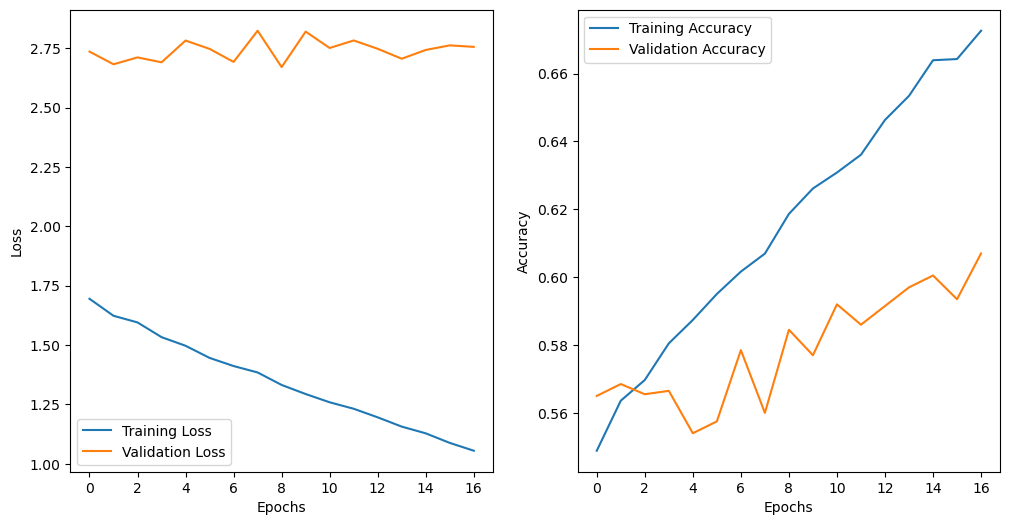

In [33]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_nxt1.history['loss'], label='Training Loss')
plt.plot(history_nxt1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_nxt1.history['accuracy'], label='Training Accuracy')
plt.plot(history_nxt1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Predicting

In [31]:
# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/Round 2/model_round21_epoch_30.h5')  # Update with your checkpoint path
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)





In [34]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

63/63 [==============================] - 61s 979ms/step


In [35]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 75.20%
Correct words predicted      : 60.85%


1/1 [==============================] - 0s 72ms/step


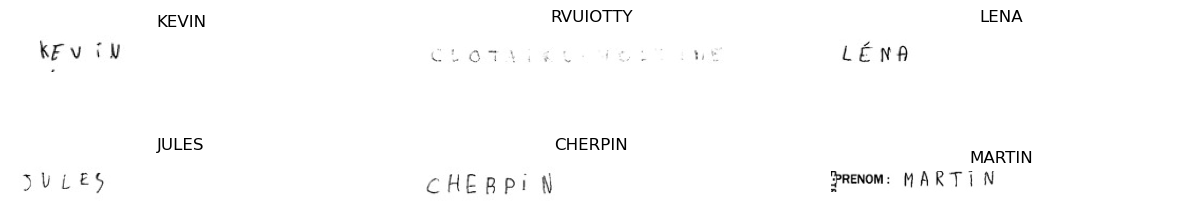

In [37]:
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [41]:
def predict(index):
    img_dir = 'test_v2/test/' + test.loc[index, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image / 255.

    # Reshape the image to have a batch size of 1
    image = image.reshape(1, 256, 64, 1)

    pred = model.predict(image)
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])

    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 90ms/step


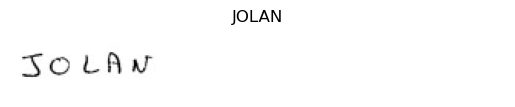

In [43]:
predict(10260)

In [27]:
#SAve the model#

In [ ]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/Round 2/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_dir + 'model_round21_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/Round 2/model_round2_epoch_30.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 30

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    history_round2 = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights...")
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


In [37]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/Round 2/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + 'model_round21s_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/Round 2/model_round21_epoch_30.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 2

try:
    # Fit the model using training and validation data, and apply the ModelCheckpoint callback
    history_round2 = model_final.fit(
        x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
        y=train_output,  # True output labels
        validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
        epochs=remaining_epochs,  # Number of training epochs
        # Start epoch numbering from 35
        batch_size=64,  # Batch size for training
        callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving weights and model...")

    # Save both the model architecture and weights
    model_final.save(os.path.join(checkpoint_dir, 'interrupted_model.h5'))
    model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights.h5'))


Epoch 1/2
313/313 [==============================] - 521s 2s/step - loss: 0.2031 - accuracy: 0.9049 - val_loss: 3.4511 - val_accuracy: 0.6620
Epoch 2/2
  4/313 [..............................] - ETA: 8:10 - loss: 0.2438 - accuracy: 0.8906Training interrupted. Saving weights and model...


In [39]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from the history
training_accuracy = history_round2.history['accuracy']
validation_accuracy = history_round2.history['val_accuracy']

# Create a list of epochs for x-axis
epochs = range(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


NameError: name 'history_round2' is not defined

In [40]:
 history_round2

NameError: name 'history_round2' is not defined

In [ ]:
from keras.models import load_model

# Load the model from the .h5 file
model = load_model('interrupted_model.h5')

# Now, you can use the loaded model for predictions or further training


In [29]:
from keras.callbacks import ModelCheckpoint
import keras
import os

# Define a directory where you want to save the checkpoints
checkpoint_dir = 'model_checkpoints/Round 2/'

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + 'model_round21s_epoch_{epoch:02d}.h5',  # Specify the file path format
    save_best_only=False,  # Save the model after each epoch
    save_weights_only=True,  # Save only the model's weights
    save_freq=1  # Save after every epoch
)

# Compile the final model with a dummy loss lambda function and accuracy metric
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Include accuracy as a metric
)

# Load the weights from the previous checkpoint
model_final.load_weights('model_checkpoints/Round 2/model_round21_epoch_30.h5')  # Update with your checkpoint path

# Continue training for the remaining epochs (57 more in your case)
remaining_epochs = 1

# Fit the model using training and validation data, and apply the ModelCheckpoint callback
history_round2 = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],  # Input data and placeholders
    y=train_output,  # True output labels
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),  # Validation data
    epochs=remaining_epochs,  # Number of training epochs
    # Start epoch numbering from 35
    batch_size=64,  # Batch size for training
    callbacks=[checkpoint_callback]  # Add the ModelCheckpoint callback
)


# Save both the model architecture and weights
model_final.save(os.path.join(checkpoint_dir, 'interrupted_model1.h5'))
model_final.save_weights(os.path.join(checkpoint_dir, 'interrupted_weights1.h5'))


313/313 [==============================] - 1924s 6s/step - loss: 0.2198 - accuracy: 0.9014 - val_loss: 4.4724 - val_accuracy: 0.4100


C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model_final.save(os.path.join(checkpoint_dir, 'interrupted_model1k.keras'))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\saving\serialization_lib.py:394: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss={'ctc': lambda y_true, y_pred: y_pred},

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [ ]:
from keras.models import load_model

# Load the model from the .h5 file
model = load_model('interrupted_model1k.keras')

# Now, you can use the loaded model for predictions or further training
